> This kernel is a XGB Tutorial with managing the memory that added code-comments and detailed descriptions based on [XGBoost Starter - LB 0.793](https://www.kaggle.com/code/cdeotte/xgboost-starter-0-793).

> TOC
```
1. Load Libraries
2. Load Dataset and Manage the GPU Memory
3. Feature Engineering
4. Train XGB
5. Save OOF Preds
6. Feature Importance
7. Data Processing and Feature Engineering for Test Data
8. Infer Test
9. Create Submission CSV
```

# 1. Load Libraries

When we train machine learning and deep learning, it is common to use the CPU to perform data preprocessing,etc. and to train the model with the GPU. And in this case, the process of copying(moving) the data loaded to the CPU to the GPU is required. For example, Working with dataframes with pandas, processing data on GPU memory with torch, and so on.

Instead of doing that now, RAPIDS came out with the concept of 'Yo, Let's do the whole process on the GPU!'. RAPIDS is a CUDA process-based data science platform built and operated by NVIDIA.

All packages are named cuxx to emphasize that they are based on CUDA. By replacing pandas with cudf, numpy with cupy, and sklearn with cuml, it has been developed to use almost the same functions as before.


In [1]:
import pandas as pd
import numpy as np

import cupy
import cudf

import matplotlib.pyplot as plt, gc, os

print('cudf version',cudf.__version__)

cudf version 21.10.01


# 2. Load Dataset and Manage the GPU Memory

When using a GPU, we need to manage our GPU resources well with monitoring currently available GPU resources through the nvidia-smi shell command, etc.

In [2]:
!nvidia-smi

Mon Jul 18 03:11:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

One Tesla P100 is available and there are currently no processes running with that GPU.

Now we will load the data onto GPU memory with cudf. The basic functions and usage are the same as in pandas.

In [3]:
# read_parquet() function reads a file in parquet format.
df = cudf.read_parquet('../input/amex-data-integer-dtypes-parquet-format/train.parquet')

In [4]:
df

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035157,0.0,0.004709,...,-1,-1,-1,0,0,0.0,<NA>,0,0.000610,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126749977,0.0,0.002714,...,-1,-1,-1,0,0,0.0,<NA>,0,0.005492,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123976685,0.0,0.009423,...,-1,-1,-1,0,0,0.0,<NA>,0,0.006986,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0,0.013683,1.002700,0.001373,0.117169224,0.0,0.005531,...,-1,-1,-1,0,0,0.0,<NA>,0,0.006527,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0,0.015193,1.000727,0.007605,0.117324777,0.0,0.009312,...,-1,-1,-1,0,0,0.0,<NA>,0,0.008126,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531446,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-11-05,0.979333,14,0.020818,0.828199,0.003487,0.090742894,0.0,0.025139,...,-1,-1,-1,0,0,0.0,<NA>,0,0.001498,0
5531447,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-12-23,0.984907,10,0.007209,0.812610,0.005904,0.079886191,0.0,0.023691,...,-1,-1,-1,0,0,0.0,<NA>,0,0.008225,0
5531448,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-01-06,0.983019,15,0.013151,0.815422,0.003457,0.100502573,0.0,0.012343,...,-1,-1,-1,0,0,0.0,<NA>,0,0.006773,0
5531449,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-02-06,0.969861,15,0.009855,1.003541,0.005117,0.101802148,0.0,0.008578,...,-1,-1,-1,0,0,0.0,<NA>,0,0.001168,0


In [5]:
!nvidia-smi

Mon Jul 18 03:11:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    38W / 250W |   3669MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Putting data on the GPU like this will take up 3669 MiB of memory in Memory-Usage. Given that the total available memory is 16280 MiB, it should be borne in mind that memory may be overwitten if the variable is copied several times or another dataset(eg, evaluation data) is loaded.

So, if you want to cleanly convert `customer_ID` to a number, you can use the hex_to_int() and astype() functions.

Let's apply that only for the last 16 characters. That's the unique characters.

In [6]:
df['customer_ID'] = df['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
df

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,-4532153018459703766,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035157,0.0,0.004709,...,-1,-1,-1,0,0,0.0,<NA>,0,0.000610,0
1,-4532153018459703766,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126749977,0.0,0.002714,...,-1,-1,-1,0,0,0.0,<NA>,0,0.005492,0
2,-4532153018459703766,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123976685,0.0,0.009423,...,-1,-1,-1,0,0,0.0,<NA>,0,0.006986,0
3,-4532153018459703766,2017-06-13,0.960384,0,0.013683,1.002700,0.001373,0.117169224,0.0,0.005531,...,-1,-1,-1,0,0,0.0,<NA>,0,0.006527,0
4,-4532153018459703766,2017-07-16,0.947248,0,0.015193,1.000727,0.007605,0.117324777,0.0,0.009312,...,-1,-1,-1,0,0,0.0,<NA>,0,0.008126,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531446,-8425848485496994175,2017-11-05,0.979333,14,0.020818,0.828199,0.003487,0.090742894,0.0,0.025139,...,-1,-1,-1,0,0,0.0,<NA>,0,0.001498,0
5531447,-8425848485496994175,2017-12-23,0.984907,10,0.007209,0.812610,0.005904,0.079886191,0.0,0.023691,...,-1,-1,-1,0,0,0.0,<NA>,0,0.008225,0
5531448,-8425848485496994175,2018-01-06,0.983019,15,0.013151,0.815422,0.003457,0.100502573,0.0,0.012343,...,-1,-1,-1,0,0,0.0,<NA>,0,0.006773,0
5531449,-8425848485496994175,2018-02-06,0.969861,15,0.009855,1.003541,0.005117,0.101802148,0.0,0.008578,...,-1,-1,-1,0,0,0.0,<NA>,0,0.001168,0


In [7]:
!nvidia-smi

Mon Jul 18 03:11:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    38W / 250W |   3353MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In order to get used to it, we will continue to track the memory as much as possible. Just truncating some of the data like this can reduce the memory being used.

About 300 MiB has been reduced.

Column `S_2`contained time information. Like pandas, the data type is changed with the to_datetime() function.

In [8]:
df['S_2'] = cudf.to_datetime(df['S_2'])
df

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,-4532153018459703766,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035157,0.0,0.004709,...,-1,-1,-1,0,0,0.0,<NA>,0,0.000610,0
1,-4532153018459703766,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126749977,0.0,0.002714,...,-1,-1,-1,0,0,0.0,<NA>,0,0.005492,0
2,-4532153018459703766,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123976685,0.0,0.009423,...,-1,-1,-1,0,0,0.0,<NA>,0,0.006986,0
3,-4532153018459703766,2017-06-13,0.960384,0,0.013683,1.002700,0.001373,0.117169224,0.0,0.005531,...,-1,-1,-1,0,0,0.0,<NA>,0,0.006527,0
4,-4532153018459703766,2017-07-16,0.947248,0,0.015193,1.000727,0.007605,0.117324777,0.0,0.009312,...,-1,-1,-1,0,0,0.0,<NA>,0,0.008126,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531446,-8425848485496994175,2017-11-05,0.979333,14,0.020818,0.828199,0.003487,0.090742894,0.0,0.025139,...,-1,-1,-1,0,0,0.0,<NA>,0,0.001498,0
5531447,-8425848485496994175,2017-12-23,0.984907,10,0.007209,0.812610,0.005904,0.079886191,0.0,0.023691,...,-1,-1,-1,0,0,0.0,<NA>,0,0.008225,0
5531448,-8425848485496994175,2018-01-06,0.983019,15,0.013151,0.815422,0.003457,0.100502573,0.0,0.012343,...,-1,-1,-1,0,0,0.0,<NA>,0,0.006773,0
5531449,-8425848485496994175,2018-02-06,0.969861,15,0.009855,1.003541,0.005117,0.101802148,0.0,0.008578,...,-1,-1,-1,0,0,0.0,<NA>,0,0.001168,0


In [9]:
!nvidia-smi

Mon Jul 18 03:11:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    38W / 250W |   3321MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

It is also important to change it to an appropriate data type. In Python's memory operation process, string types use a lot of memory by default. So, if you can encode a categorical variable or change it to an integer type, it is advantageous for memory management.

In [10]:
df.isna().sum()

customer_ID          0
S_2                  0
P_2              45985
D_39                 0
B_1                  0
                ...   
D_141           101548
D_142          4587043
D_143                0
D_144            40727
D_145                0
Length: 190, dtype: uint64

There are a lot of empty cells. We will use the fillna() function to fill empty cells with -127. The lowest number that can be expressed in 1 byte(8-bits) is -129. A signed integer can be represented from -128 to 127, and it seems that the original author wanted to replace null values with minimal memory usage.

However, since it is a processing that does not consider the distribution of each variable, there may be some disadvantages in model training.

And in the original text, when executing the fillna() function with cudf, it was written as `df = df.fillna(NAN_VALUE)`, but we will write it as `df.fillna(NAN_VALUE, inplace=True)`. When written as in the original code, the GPU memory usage nearly doubles (3321MiB -> 6079MiB) as the null-padded df is copied and allocated to a new memory address. Since we are not working on a sufficient memory environment, we must set the `inplace=Tru` option to overwrite the currently allocated memory address.

In [11]:
df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Columns: 190 entries, customer_ID to D_145
dtypes: datetime64[ns](1), float32(93), int16(9), int64(1), int8(86)
memory usage: 2.6 GB


In [12]:
NAN_VALUE = -127 
df.fillna(NAN_VALUE, inplace=True)
df.isna().sum()

customer_ID    0
S_2            0
P_2            0
D_39           0
B_1            0
              ..
D_141          0
D_142          0
D_143          0
D_144          0
D_145          0
Length: 190, dtype: uint64

In [13]:
!nvidia-smi

Mon Jul 18 03:11:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    38W / 250W |   3233MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

The read_file_GPU() function below performs this process at once.

In the original code, it was written only in such a way that GPU is used, but it is difficult to proceed with Kaggle servel. Therefore, we use the CPU in the process of loading the entire data, and in the process of learning or evaluating the data, So we will make another read_file_CPU() function.

And we do not have enough CPU on Kaggle server. So if data is uploaded at once in the process of loading the test dataset later, the CPU memory will be exceeded and the Kaggle kernel is reset. Our CPU based function can load the data to CPU in batches and then, load the data to GPU in iteration form. 

If you want to load data to the CPU, you can use pandas, and if you load data to the GPU,  you can use cudf.

In [14]:
from pyarrow.parquet import ParquetFile

In [15]:
# original code
def read_file_GPU(path = '', usecols = None):
    # read_parquet() function can read the parquet-type file.
    # if you want to specify columns:
    if usecols is not None: 
        df = cudf.read_parquet(path, columns=usecols)
    # if you want to read all columns:
    else: df = cudf.read_parquet(path)
    
    df['customer_ID'] = df['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
    df.S_2 = cudf.to_datetime( df.S_2 )
    df = df.fillna(NAN_VALUE) 
    print('shape of data:', df.shape)
    
    return df

# modified code(CPU, batch load)
def read_file_CPU(path = '', iter_batch = None, usecols = None):
    if usecols is not None:
        # when retrieving only some columns(1~3), there is no problem even if all rows are retrieved.
        df = pd.read_parquet(path, columns=usecols)
    else:
        # When importing all columns, data is imported in batch format.
        df = iter_batch
    
    # it performs the same processing as it did with cudf.
    df['customer_ID'] = df['customer_ID'].apply(lambda x : int(x[-16:],16)).astype('int64') 
    df.S_2 = pd.to_datetime( df.S_2 )
    df.fillna(NAN_VALUE, inplace=True)
    print('shape of data:', df.shape)
    
    return df

# print('Reading train data...')
# TRAIN_PATH = '../input/amex-data-integer-dtypes-parquet-format/train.parquet'
# train = read_file(path = TRAIN_PATH)

The original kernel used variable name as train, not df. So we'll make it the same.

However, the copy() function is not used here fore memory management. If you use the copy() function, it will be copied to another memory address.

In [16]:
train = df
train.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,-4532153018459703766,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,...,-1,-1,-1,0,0,0.0,-127.0,0,0.000610,0
1,-4532153018459703766,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,0.002714,...,-1,-1,-1,0,0,0.0,-127.0,0,0.005492,0
2,-4532153018459703766,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,0.009423,...,-1,-1,-1,0,0,0.0,-127.0,0,0.006986,0
3,-4532153018459703766,2017-06-13,0.960384,0,0.013683,1.002700,0.001373,0.117169,0.0,0.005531,...,-1,-1,-1,0,0,0.0,-127.0,0,0.006527,0
4,-4532153018459703766,2017-07-16,0.947248,0,0.015193,1.000727,0.007605,0.117325,0.0,0.009312,...,-1,-1,-1,0,0,0.0,-127.0,0,0.008126,0


In [17]:
!nvidia-smi

Mon Jul 18 03:11:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    38W / 250W |   3233MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

You can see that additional memory is not used because only the variable name is changed(refer to memory) without copying.

# 3. Feature Engineering

We do not put data as it is to the model, but transform it into statistical values before training and then train it.

In the process of data aggregation, the column takes on a multiindex format, but in order to include it in the model, a one-dimensional column must be maintained. So, Let's take a look at this task first and then run the whole process through a function.

In [18]:
multi_index_col_sample = train.groupby('customer_ID')[['B_30','B_38','D_114']].agg(['count','last','nunique']).columns
multi_index_col_sample

MultiIndex([( 'B_30',   'count'),
            ( 'B_30',    'last'),
            ( 'B_30', 'nunique'),
            ( 'B_38',   'count'),
            ( 'B_38',    'last'),
            ( 'B_38', 'nunique'),
            ('D_114',   'count'),
            ('D_114',    'last'),
            ('D_114', 'nunique')],
           )

In [19]:
['_'.join(x) for x in multi_index_col_sample]

['B_30_count',
 'B_30_last',
 'B_30_nunique',
 'B_38_count',
 'B_38_last',
 'B_38_nunique',
 'D_114_count',
 'D_114_last',
 'D_114_nunique']

We can make it easier to see by attaching the double index as a one-dimensional index. Then, Let's check the entire function.

In [20]:
def process_and_feature_engineer(df):
    # Put the remaining column names int the all_cols variable except for the customer_ID column and S_2 column in a list comprehension method.
    # Columns in all_cols are the variables for training.
    all_cols = [c for c in list(df.columns) if c not in ['customer_ID','S_2']]
    
    # Let's split the all_cols categorical variables and numerical variables.
    # In the original code, categorical variables are splited like below but i find the others remained.
    # But to maintain the countinuity and avoid confusion, we will use it as is.
    cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
    num_features = [col for col in all_cols if col not in cat_features]

    # And aggregate numerical variables into statistics for each customer_ID.
    test_num_agg = df.groupby("customer_ID")[num_features].agg(['mean', 'std', 'min', 'max', 'last'])
    # Aggregated columns are the type of MultiIndex. So connect them with '_' charactor like that we checked above.
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]

    # Similary, Aggregate categorical variables for each customer_ID.
    # 'count' is count the duplicate customer_ID's.
    # 'last' is get the last value of each categorical variables.
    # nunique() count the unique values of each categorical variables.
    test_cat_agg = df.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique'])
    test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]

    # Merge the numerical variables and categorical variables.
    df = cudf.concat([test_num_agg, test_cat_agg], axis=1)
    del test_num_agg, test_cat_agg
    print('shape after engineering', df.shape)
    
    return df


train = process_and_feature_engineer(train)

shape after engineering (458913, 918)


In [21]:
train

,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,D_39_last,...,D_63_nunique,D_64_count,D_64_last,D_64_nunique,D_66_count,D_66_last,D_66_nunique,D_68_count,D_68_last,D_68_nunique
customer_ID,,,,,,,,,,,,,,,,,,,,,
-9223358381327749917,0.415868,0.057145359,0.340178,0.498727,0.387708,2.615385,4.628506986,0,16,0,...,1,13,2,1,13,-1,1,13,3,2
-9223193039457028513,0.974068,0.013093883,0.964483,1.002478,1.001372,0.000000,0.0,0,0,0,...,2,13,0,1,13,-1,1,13,6,1
-9223189665817919541,0.802447,0.038025034,0.694073,0.828761,0.694073,0.000000,0.0,0,0,0,...,1,13,0,1,13,-1,1,13,6,1
-9223188534444851899,0.791203,0.002687729,0.786647,0.794826,0.787945,0.000000,0.0,0,0,0,...,1,13,3,2,13,-1,1,13,5,1
-9223173911659837606,0.115666,0.078554217,0.038207,0.252421,0.040486,4.384615,6.144624501,0,17,13,...,1,13,0,2,13,-1,1,13,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9223275399009481284,0.508722,0.034856297,0.446763,0.580708,0.502093,3.769231,8.427671151,0,31,8,...,1,13,3,1,13,-1,1,13,6,1
9223300670094807586,0.128279,0.138330718,-0.035435,0.395510,0.118304,5.461538,6.213096177,1,22,6,...,1,13,3,2,13,-1,1,13,5,2
9223303087902649707,0.364807,0.074824325,0.271125,0.517709,0.368901,3.692308,8.576951822,0,23,0,...,1,13,2,1,13,-1,1,13,3,2


In [22]:
!nvidia-smi

Mon Jul 18 03:11:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    38W / 250W |   5399MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

As the number of columns increased, the data capacity also increased.

We can load the target(label) data also. We will merge it into the train dataset created above.

At this time, customer_ID must be processed as an integer in the same way as before. 

This task is to predict whether the customer will or will not pay the card expenses. Each customer's real repayment status is contained in train_labels.csv.

In [23]:
targets = cudf.read_csv('../input/amex-default-prediction/train_labels.csv')
targets['customer_ID'] = targets['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
targets = targets.set_index('customer_ID')

# The index is the same as customer_ID, Merge based on the corresponding index.
train = train.merge(targets, left_index=True, right_index=True, how='left')
# Store the target data as an 8-bit integer.
train.target = train.target.astype('int8')

In [24]:
train = train.reset_index()
train

,customer_ID,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,...,D_64_count,D_64_last,D_64_nunique,D_66_count,D_66_last,D_66_nunique,D_68_count,D_68_last,D_68_nunique,target
0,-8156314619613718096,0.321566,0.066840,0.222667,0.434527,0.400919,27.000000,8.990736,1,34,...,13,0,1,13,-1,1,13,6,1,1
1,-8155545852312209511,0.572579,0.111607,0.441690,0.722336,0.531762,14.923077,7.239493,0,23,...,13,3,1,13,-1,1,13,5,2,1
2,-8155819641925061224,0.542401,0.049866,0.492097,0.635385,0.492097,8.307692,8.148462,0,24,...,13,0,1,13,-1,1,13,6,1,1
3,-8155202144177835732,0.525616,0.069431,0.300241,0.572156,0.300241,2.538462,4.993586,0,18,...,13,0,1,13,-1,1,13,5,1,1
4,-8156085982564465946,0.966729,0.022636,0.936331,1.005958,1.005958,2.923077,4.716311,0,13,...,13,2,1,13,-1,1,13,6,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458908,9185902206605172295,0.899148,0.002162,0.895734,0.903749,0.898409,10.692308,8.547754,0,21,...,13,0,1,13,-1,1,13,6,1,0
458909,9185131784716738470,0.094862,0.102545,-0.036141,0.361963,0.216669,6.769231,10.026248,0,35,...,13,0,1,13,-1,1,13,6,1,1
458910,9185623865183437977,0.388658,0.049609,0.327292,0.446901,0.327292,1.384615,2.631174,0,10,...,13,0,2,13,-1,1,13,5,1,0
458911,9185387076984189087,0.159254,0.061890,-0.007504,0.221426,-0.007504,0.615385,2.218801,0,8,...,13,3,2,13,-1,1,13,4,1,1


In [25]:
!nvidia-smi

Mon Jul 18 03:11:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    38W / 250W |   7599MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

The targets are now merged into the train dataset, so deallocate them in memory.

Although the capacity is small, it is better to always manage the memory after using the variable.

In [26]:
del targets

In [27]:
!nvidia-smi

Mon Jul 18 03:11:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    38W / 250W |   7591MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Count the number of features to train the model, The first column is the id value and the last column is the label. Excluding 2 columns, the remaining number of columns is 198.

In [28]:
FEATURES = train.columns[1:-1]
print(f'There are {len(FEATURES)} features!')

There are 918 features!


# 4. Train XGB

When training the model, we will utilize KFold cross-validation to avoid overfitting by using all data at lease once for traininig.

There is a problem in that the parts corresponding to 30 and 20 cannot be used for learning when the data is divided into learning/verification, such as 0:30 or 80:20 which are generally used for convenience. KFold splits training data and validation data(expressed as creating K-Folds) so that all datasets can be used for trainig.

In [29]:
# LOAD XGB LIBRARY
from sklearn.model_selection import KFold
import xgboost as xgb
print('XGB Version',xgb.__version__)

# XGB MODEL PARAMETERS
xgb_parms = { 
    'max_depth':4, 
    'learning_rate':0.05, 
    'subsample':0.8,
    'colsample_bytree':0.6, 
    'eval_metric':'logloss',
    'objective':'binary:logistic',
    'tree_method':'gpu_hist',
    'predictor':'gpu_predictor',
    'random_state':42
}

XGB Version 1.6.1


When traininig, we use DeviceQuantileDMatrix. All of usable-GPU memory is used at once for each calculation. And this DeviceQuantileDMatrix allows you to use GPU memory by dividing it into smaller units.

In order to use DeviceQuantileDMatrix, it is necessary to define a class that can pass data in batch form by repeatedly calling the iteration method, that is, the next() function.

In [30]:
class IterLoadForDMatrix(xgb.core.DataIter):
    def __init__(self, df=None, features=None, target=None, batch_size=256*1024):
        self.features = features
        self.target = target
        self.df = df
        # It will start from 0 and increase by 1 until all of data is passed.
        self.it = 0 
        self.batch_size = batch_size
        # np.ceil()은 a function that rounds up the float.
        # Calculate the number of batches by dividing the data by the batch size
        self.batches = int( np.ceil( len(df) / self.batch_size ) )
        super().__init__()

    def reset(self):
        '''Reset the iterator'''
        # If you need to perform iteration again from the beginning, 
        # you can initialize it with the reset() function.
        self.it = 0

    def next(self, input_data):
        '''Yield next batch of data.'''
        # self.batches defined at class instance creation. It contains the total number of batches that can be passed.
        # End the iteration when self.it has reached the number of deliverable batches.
        if self.it == self.batches:
            # 
            return 0 
        
        # Get the start-end point for indexing.
        a = self.it * self.batch_size
        b = min( (self.it + 1) * self.batch_size, len(self.df) )
        # Contain the data that will be passed by batch to the variable dt.
        dt = cudf.DataFrame(self.df.iloc[a:b])
        # Pass the feature and target from dt to input.
        input_data(data=dt[self.features], label=dt[self.target]) 
        self.it += 1
        return 1

The function below is the logic to evaluate the model in the American Express - Default Prediction contest. It will be used as a criterion for optimization during model training.

In this tutorial, I expanded the original kernel that uses only CPUs for this calculation to select CPU and GPU. If you want to train the model using the train data on the GPU as it is, you must use the amex_metric_mod_GPU() function, which calculate optimization on the GPU. Here, we use amex_metric_mod_CPU().

In [31]:
def amex_metric_mod_CPU(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)

def amex_metric_mod_GPU(y_true, y_pred):

    labels     = cupy.transpose(cupy.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = cupy.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[cupy.cumsum(weights) <= int(0.04 * cupy.sum(weights))]
    top_four   = cupy.sum(cut_vals[:,0]) / cupy.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = cupy.transpose(cupy.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = cupy.where(labels[:,0]==0, 20, 1)
        weight_random  = cupy.cumsum(weight / cupy.sum(weight))
        total_pos      = cupy.sum(labels[:, 0] *  weight)
        cum_pos_found  = cupy.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = cupy.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)

Finally, we train the model, To make efficient use of the limited GPU, we will load the dataset down to the CPU first. Then, in the IterLoadForDMatrix() function, indexing in small units through cudf and loading memory to the GPU goes through.

Since we have already loaded the training data into cudf and allocated it to the GPU memory, we will load it down to the CPU through the to_pandas() function. The to_pandas() function allows you to safely copy to CPU resources while transform cudf object into a pandas dataframe object.

In fact, if you use the RAPIDS platform, it is effective to perform all processes with a GPU, but there are many practical difficulties in applying it completely with a small amount of memory. Since we use Kaggle servers, it is important to make the best use of CPU and GPU memory like this.

To 'copy' means to remain in GPU memory. Let's check the resource status before and after copying together.

In [32]:
!nvidia-smi

Mon Jul 18 03:11:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    38W / 250W |   7591MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [33]:
train_cpu = train.to_pandas()

In [34]:
!nvidia-smi

Mon Jul 18 03:12:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    38W / 250W |   7591MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

From now on, as multiple functions refer to multiple variables, and the allocated memory is called around, instantaneous memory usage will fluctuate. In Python, it is not necessary to manually manage memory because the garbage collector(which increases the available memory by deallocating the memory when the value allocated to a specific memory is not being referenced more than once) works internally.

However, since optimization is not performed in real time for every execution, it is very helpful for optimization by manually operating the garbage collector through the gc.collect() function for every batch during model training and evaluation. So, let's run the function and move on.

In [35]:
import gc

In [36]:
gc.collect()

63

We will set The K of KFold to 5. Then, for each of the 5 folds, we will have 4 learning folds and 1 validatio fold, and repeat learning a total of 5 times by moving the position of the valiation folds. As a result, the optimization is carried out through the average value of the 5 verification results.

SEED can be specified with any number.

In [37]:
FOLDS = 5
SEED = 42
skf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

In [38]:
importances = []
oof = []
TRAIN_SUBSAMPLE = 1.0
VER = 1 # Version information to record when saving the model.

# To perform cross-validation on the KFold object skf, iterative validation is performed after separating into training and validation folds.
for fold,(train_idx, valid_idx) in enumerate(skf.split(train_cpu, train_cpu.target)):
    
    # If you want to train model by only using some sample of the train data, set TRAIN_SUBSAMLE to less than 1.
    # Then, you can configure the train set again by randomly extracting the ratio through the if statement below.
    if TRAIN_SUBSAMPLE<1.0:
        np.random.seed(SEED)
        train_idx = np.random.choice(train_idx, int(len(train_idx)*TRAIN_SUBSAMPLE), replace=False)
        np.random.seed(None)
    
    print('#'*25)
    print('### Fold',fold+1)
    print('### Train size',len(train_idx),'Valid size',len(valid_idx))
    print(f'### Training with {int(TRAIN_SUBSAMPLE*100)}% fold data...')
    print('#'*25)
    
    # Create the IterLoadForDMatrix instance. It will throw data in batches for training model. 
    Xy_train = IterLoadForDMatrix(train_cpu.loc[train_idx], FEATURES, 'target')
    
    # Define validation data to verify performance while training.
    X_valid = train_cpu.loc[valid_idx, FEATURES]
    y_valid = train_cpu.loc[valid_idx, 'target']
    
    dtrain = xgb.DeviceQuantileDMatrix(Xy_train, max_bin=256)
    dvalid = xgb.DMatrix(data=X_valid, label=y_valid)
    
    # train the model
    model = xgb.train(xgb_parms, 
                dtrain=dtrain,
                evals=[(dtrain,'train'),(dvalid,'valid')],
                num_boost_round=9999,
                early_stopping_rounds=100,
                verbose_eval=100) 
    # During cross-validation, the model is saved at each verification.
    model.save_model(f'XGB_v{VER}_fold{fold}.xgb')
    
    # After training the model, we will check the feature importance. 
    # For this, importance is calculated for each training and stored in a variable dd.
    dd = model.get_score(importance_type='weight')
    df = pd.DataFrame({'feature':dd.keys(),f'importance_{fold}':dd.values()})
    importances.append(df)
    
    # Validate the model. 
    oof_preds = model.predict(dvalid)
    
    # For calculating Accuracy, we uses the competition evaluation metric.
    # In the original code, y_valied.values is put as it is,
    # If not train_cpu but train that loaded in GPU memory was used as an argument,
    # y_valid.values would be cupy._core.core.ndarray rather than np.ndarray.
    # In this case, use cupy to let it compute directly on the GPU.
    # -> acc = amex_metric_mod_GPU(y_valid.values, oof_preds)

    # Since we use train_cpu loaded to the cpu as in the original code,
    # The variable is np.ndarray(). So, we can just put it in amex_metric_mod_CPU().
    acc = amex_metric_mod_CPU(y_valid.values, oof_preds)
    print('Kaggle Metric =',acc,'\n')
    
    # Also save the verification score(oof_pred) separately.
    df = train_cpu.loc[valid_idx, ['customer_ID','target']].copy()
    df['oof_pred'] = oof_preds
    oof.append( df )
    
    # Let's free All variables used for training from memory.
    del dtrain, Xy_train, dd, df
    del X_valid, y_valid, dvalid, model
    # And excecute garbage collection to completely remove the remaining non-referenced memory values even after the variable has been removed.
    _ = gc.collect()
    
print('#'*25)
# When training is finished, the entire verification result is saved as a DataFrame.
# Then, calculate the actual value and the verification value as an evaluation metric.
# Here, if you use the train variable loaded in GPU memory as an argument like y_valid,
# It would be not a pandas.core.frame.DataFrame, but a cudf.core.dataframe.DataFrame.
# So, In this case, either merge them with cudf or replace all elements in oof with pandas's DataFrame objects.
# Since we used train_cpu, we use pandas as is.
oof = pd.concat(oof,axis=0,ignore_index=True).set_index('customer_ID')
acc = amex_metric_mod_GPU(oof.target.values, oof.oof_pred.values)
print('OVERALL CV Kaggle Metric =',acc)

#########################
### Fold 1
### Train size 367130 Valid size 91783
### Training with 100% fold data...
#########################
[0]	train-logloss:0.66284	valid-logloss:0.66284
[100]	train-logloss:0.23713	valid-logloss:0.23815
[200]	train-logloss:0.22281	valid-logloss:0.22603
[300]	train-logloss:0.21671	valid-logloss:0.22208
[400]	train-logloss:0.21262	valid-logloss:0.22020
[500]	train-logloss:0.20944	valid-logloss:0.21912
[600]	train-logloss:0.20667	valid-logloss:0.21838
[700]	train-logloss:0.20411	valid-logloss:0.21785
[800]	train-logloss:0.20184	valid-logloss:0.21751
[900]	train-logloss:0.19960	valid-logloss:0.21728
[1000]	train-logloss:0.19749	valid-logloss:0.21707
[1100]	train-logloss:0.19555	valid-logloss:0.21693
[1200]	train-logloss:0.19363	valid-logloss:0.21686
[1300]	train-logloss:0.19174	valid-logloss:0.21667
[1400]	train-logloss:0.18987	valid-logloss:0.21662
[1498]	train-logloss:0.18814	valid-logloss:0.21666
Kaggle Metric = 0.7901056107799863 

#####################

In [39]:
# Now that training is over, the train_cpu dataset is no longer needed.
# We will also clean up the memory referring to the train_cpu data. 
del train, train_cpu
_ = gc.collect()

In [40]:
!nvidia-smi

Mon Jul 18 03:21:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    40W / 250W |   7823MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 5. Save OOF Preds

We have to save the prediction result with customer_ID. Just get the unique id information from the data file, change the hexadecimal number to an integer type as we did before, and merge the predicted values obtained during the training process.

In [41]:
TRAIN_PATH = '../input/amex-data-integer-dtypes-parquet-format/train.parquet'
oof_xgb = pd.read_parquet(TRAIN_PATH, columns=['customer_ID']).drop_duplicates()
oof_xgb['customer_ID_hash'] = oof_xgb['customer_ID'].apply(lambda x: int(x[-16:],16) ).astype('int64')
oof_xgb = oof_xgb.set_index('customer_ID_hash')
oof_xgb = oof_xgb.merge(oof, left_index=True, right_index=True)
oof_xgb = oof_xgb.sort_index().reset_index(drop=True)
oof_xgb.to_csv(f'oof_xgb_v{VER}.csv',index=False)
oof_xgb.head()

,customer_ID,target,oof_pred
0,20eac26171c3d251c55fc78204e59fab1c15fc2bc96d0c...,1,0.671838
1,aea50fdf9b974ccec95fa177c3225a0f913483b457de6e...,0,0.000246
2,32cd2d41aef737b69089882754395925c96eaee1f4a859...,0,0.002053
3,8daa6d5dc2655a8a437531e6b8b96829113cdfe9bf6cae...,0,0.012740
4,0ceba351a3851202542feb49d7385bcef32f6037fc57c7...,1,0.852884


Visualize the prediction results. The prediction result is a probability between 0 and 1. Since only 5% default(1) and the rest should be predicted as 0, the visualization is biased towards 0 and 1 in both directions, but there should be more values distributed at 0.

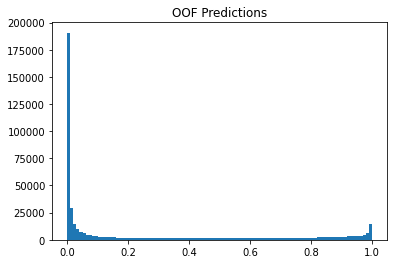

In [42]:
plt.hist(oof_xgb.oof_pred.values, bins=100)
plt.title('OOF Predictions')
plt.show()

Now that we have the forecasts saved as a csv file, we remove the variables. The reason for repeating this process of saving to a file and freeing memory is that the RAM supported by Kaggle is not that large. In general, even in the local environment, RAM is not enough, so it may shut down while referencing or copying the memory. 

So, to prevent this, it is recommended to save files to the hard-disk and keep the RAM lightly.

In [43]:
del oof_xgb, oof
_ = gc.collect()

In [44]:
!nvidia-smi

Mon Jul 18 03:21:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    40W / 250W |   7823MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 6. Feature Importance

Feature Importance is information about which variable is highly utilized in the model's task(prediction. here). 

After traininig the model, looking at this, if there are variables that are not important to the prediction, they will be removed, and the variables with excessive importance will go through a feedback process such as checking causality or correlation with the prediction target.

In [45]:
import matplotlib.pyplot as plt

# While performing cross-validation, importances must have been accumulated as mush as the number of FOLDs(5).
# So, Calculate the average importance per feature by merging into the df variable.
df = importances[0].copy()
for k in range(1,FOLDS):
    df = df.merge(importances[k], on='feature', how='left')
df['importance'] = df.iloc[:,1:].mean(axis=1)
df = df.sort_values('importance',ascending=False)
df.to_csv(f'xgb_feature_importance_v{VER}.csv',index=False)

In [46]:
df

,feature,importance_0,importance_1,importance_2,importance_3,importance_4,importance
4,P_2_last,291.0,331.0,287.0,299.0,329.0,307.4
9,D_39_last,197.0,203.0,204.0,215.0,213.0,206.4
39,B_3_last,160.0,157.0,174.0,161.0,201.0,170.6
59,B_4_last,163.0,179.0,146.0,166.0,170.0,164.8
0,P_2_mean,160.0,169.0,153.0,138.0,189.0,161.8
...,...,...,...,...,...,...,...
542,D_93_max,1.0,NaN,NaN,NaN,NaN,1.0
72,R_2_max,1.0,1.0,NaN,NaN,NaN,1.0
644,B_39_min,1.0,1.0,NaN,1.0,1.0,1.0
431,D_82_min,1.0,1.0,NaN,1.0,1.0,1.0


Visualize only the top 20 features by importance with a bar chart.

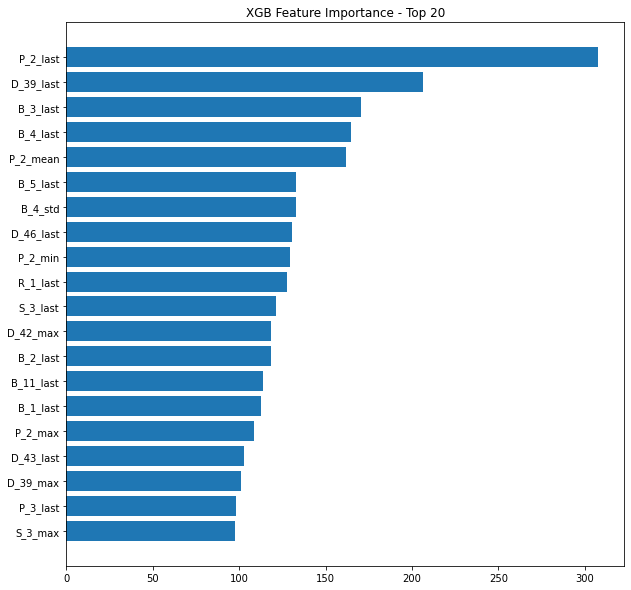

In [47]:
NUM_FEATURES = 20
plt.figure(figsize=(10,5*NUM_FEATURES//10))
plt.barh(np.arange(NUM_FEATURES,0,-1), df.importance.values[:NUM_FEATURES])
plt.yticks(np.arange(NUM_FEATURES,0,-1), df.feature.values[:NUM_FEATURES])
plt.title(f'XGB Feature Importance - Top {NUM_FEATURES}')
plt.show()

# 7. Data Processing and Feature Engineering for Test Data

We wonder if a particular customer will repay the expense. So, let's get the unique customer_ID first.

In [48]:
TEST_PATH = '../input/amex-data-integer-dtypes-parquet-format/test.parquet'
test = read_file_CPU(path = TEST_PATH, usecols = ['customer_ID','S_2'])
test

shape of data: (11363762, 2)


,customer_ID,S_2
0,8717704911770597815,2019-02-19
1,8717704911770597815,2019-03-25
2,8717704911770597815,2019-04-25
3,8717704911770597815,2019-05-20
4,8717704911770597815,2019-06-15
...,...,...
11363757,-1477111782539041971,2018-12-19
11363758,-1477111782539041971,2019-01-19
11363759,-1477111782539041971,2019-02-17
11363760,-1477111782539041971,2019-03-19


In [49]:
customers = test[['customer_ID']].drop_duplicates().sort_index().values.flatten()
customers

array([ 8717704911770597815,  4783907996972277493,  4616129756878093544,
       ...,   674735392150270193,  3353833074890263815,
       -1477111782539041971])

In this way, ID information is secured, and the default is predicted for each ID. Now we will load the test dataset. For now we needs only 2 columns, but like the train data, full dataset is very large. Therefore, we will load the dataset to the CPU in batch form as many as PART's, then pass each PART to the GPU so that the model can make predictions.

To do this, a criterion for dividing the PART is required. And the criterion requires two things: the row size in the test dataset before the duplicate customer_ID is removed, and the constant chunk size that after removing the duplicate.

Do you remember the process_and_feature_engineer() function we created earlier? If the function passes, the duplicate of customer_ID is removed through group_by aggregation and it is replaced with statistical values. This is a method of performing prediction by passing the transformed dataset in chunk size.

So, let's create a function for this process and execute that.

In [50]:
def get_rows(customers, test, NUM_PARTS = 10, verbose = ''):
    # One chunk(size of PART) can be obtained by dividing the size of the entire test-dataset by the number of PARTs.
    # It is similar to finding the batch size when training the model.
    chunk = len(customers)//NUM_PARTS
    if verbose != '':
        print(f'We will process {verbose} data as {NUM_PARTS} separate parts.')
        print(f'There will be {chunk} customers in each part (except the last part).')
        print('Below are number of rows in each part:')
    rows = []

    for k in range(NUM_PARTS):
        # Keep the remain to cc if this PART is the last one.
        if k==NUM_PARTS-1: 
            cc = customers[k*chunk:]
        # If not the last PART, cut it in chunks from the front and put it in cc.
        else: 
            cc = customers[k*chunk:(k+1)*chunk]
        # Calculate the PART size by finding the number of customer_IDs included in the current PART.
        s = test.loc[test.customer_ID.isin(cc)].shape[0]
        # rows contain the size of 10 PARTs.
        rows.append(s)
    if verbose != '': print( rows )
    return rows, chunk



Now, with the function created above, we will divide customer_ID into a total of 10 groups(PARTs)

In [51]:
# In the original code, the test dataset was divided into four.
# But in case of using a kaggle server, you will get a GPU memory overflow error when you specify 4r, so we will divide it into 10.
NUM_PARTS = 10
rows,num_cust = get_rows(customers, test[['customer_ID']], NUM_PARTS = NUM_PARTS, verbose = 'test')

We will process test data as 10 separate parts.
There will be 92462 customers in each part (except the last part).
Below are number of rows in each part:
[1136415, 1137255, 1135580, 1135734, 1136082, 1137166, 1136612, 1137228, 1136301, 1135389]


On the last line, the size of each PART is printed. The size referred to here is the size including duplicates from the raw test dataset, not the chunk size.

Therefore, it should be equal to the size of the test dataset when added together.

In [52]:
sum(rows) == len(test)

True

and chunk size is,

In [53]:
num_cust

92462

Remove the loaded test data and deallocate memory.

In [54]:
del test
_ = gc.collect()

In [55]:
!nvidia-smi

Mon Jul 18 03:22:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    35W / 250W |   7823MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 8. Infer Test

Through the code below, we divide the data into 10 PARTs through iteration, and then process the data for modeling and predict default using our model. The specific process is as follows.

1. Devide the original test dataset into batches so that each PART can be included and load it to the CPU memory.
2. The PART is loaded to the GPU for calculation again,
3. Using the process_and_feature_engineering() function, convert raw data to statistical dataset for prediction.
4. Then, the shape of dataset will be different. At this time, indexing can be performed with the chunk size obtained above.
5. Index by chunk size and then predict default with the model.
6. When prediction for all chunks is finished, merge and return the prediction result for the entire customer_ID.

In [56]:
skip_rows = 0
skip_cust = 0
test_preds = []

# Create an iteration object. By calling the object, you can raise as many rows as PART units to the CPU memory.
TEST_PATH = '../input/amex-data-integer-dtypes-parquet-format/test.parquet'
batch = ParquetFile(TEST_PATH)
# Since batch_size is fixed at one time call, it is not possible to get a different PARt size each time.
# Because of this, the customer_ID that should be predicted in the current batch is possible to already be loaded in the previous batch.
# So, set the batch size to the largest PART size, and merge it with the previous PART so that all customer_IDs can be indexed.
prev_batch = pd.DataFrame()
for pres_batch, k in zip(batch.iter_batches(batch_size=max(rows)), range(NUM_PARTS)): 
    print(f'\nReading test data...')
    # Merge the dataset loaded from the previous batch and the current batch.
    iter_batch = pd.concat([prev_batch, pres_batch.to_pandas()])
    test_cpu = read_file_CPU(iter_batch = iter_batch, path = TEST_PATH)
    # Then, Overwitten the previous batch with the current(present) batch.
    # And clear the memory.
    prev_batch = pres_batch.to_pandas()
    del pres_batch, iter_batch
    _ = gc.collect()
    
    # Load the PART into the GPU memory for pre-processing.
    test_gpu = cudf.DataFrame(test_cpu)
    skip_rows += rows[k]
    print(f'=> Test part {k+1} has shape', test_gpu.shape)
    
    # With preprocessing, statistics are obtained for each customer_ID, and duplicate customer_IDs are removed.
    # process_and_feature_engineer() uses cudf internally, not pandas.
    # So, when preprocessing, the data must be placed on the GPU.
    test_gpu = process_and_feature_engineer(test_gpu)
    
    # num_cust is the chunk size for de-duplicated customer_ID.
    # We will do the credit default prediction for all customer_IDs by increasing the chunk size.
    if k==NUM_PARTS-1: 
        test_gpu = test_gpu.loc[customers[skip_cust:]]
    else: 
        test_gpu = test_gpu.loc[customers[skip_cust:skip_cust+num_cust]]
    skip_cust += num_cust
    print('shape after indexing(by chunk size)', test_gpu.shape)
    
    # Pass the features excluding the label from the test data to X_test.
    X_test = test_gpu[FEATURES]
    dtest = xgb.DMatrix(data=X_test)
    del X_test
    gc.collect()

    # With our trained model, we can predict default.
    # Our model was trained by cross-validation.
    # Prediction is perfromed in the same way, and the prediction result can be obtained as the average value of all FOLD results.
    model = xgb.Booster()
    model.load_model(f'XGB_v{VER}_fold0.xgb')
    preds = model.predict(dtest)
    for f in range(1,FOLDS):
        model.load_model(f'XGB_v{VER}_fold{f}.xgb')
        preds += model.predict(dtest)
    preds /= FOLDS
    test_preds.append(preds)

    # free the memory
    del dtest, model
    _ = gc.collect()


Reading test data...
shape of data: (1137255, 190)
=> Test part 1 has shape (1137255, 190)
shape after engineering (92532, 918)
shape after indexing(by chunk size) (92462, 918)

Reading test data...
shape of data: (2274510, 190)
=> Test part 2 has shape (2274510, 190)
shape after engineering (184991, 918)
shape after indexing(by chunk size) (92462, 918)

Reading test data...
shape of data: (2274510, 190)
=> Test part 3 has shape (2274510, 190)
shape after engineering (185063, 918)
shape after indexing(by chunk size) (92462, 918)

Reading test data...
shape of data: (2274510, 190)
=> Test part 4 has shape (2274510, 190)
shape after engineering (185194, 918)
shape after indexing(by chunk size) (92462, 918)

Reading test data...
shape of data: (2274510, 190)
=> Test part 5 has shape (2274510, 190)
shape after engineering (185142, 918)
shape after indexing(by chunk size) (92462, 918)

Reading test data...
shape of data: (2274510, 190)
=> Test part 6 has shape (2274510, 190)
shape after en

# 9. Create Submission CSV

Finally, create a file for submission and visualize the test results.

In [57]:
len(test_preds)

10

In [58]:
# File for submission can be saved according to the format of the competition guide.
test_preds = np.concatenate(test_preds)
test = cudf.DataFrame(index=customers,data={'prediction':test_preds})
sub = cudf.read_csv('../input/amex-default-prediction/sample_submission.csv')[['customer_ID']]
sub['customer_ID_hash'] = sub['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
sub = sub.set_index('customer_ID_hash')
sub = sub.merge(test[['prediction']], left_index=True, right_index=True, how='left')
sub = sub.reset_index(drop=True)

sub.to_csv(f'submission_xgb_v{VER}.csv',index=False)
print('Submission file shape is', sub.shape )
sub.head()

Submission file shape is (924621, 2)


,customer_ID,prediction
0,03999d5e3bd61a69504cc6e7025c260c1ed2e5b449dba5...,0.099025
1,039b4f21aa584fb0c3c7055beabc098af55013f9f25515...,0.007076
2,039a6aea85575ebd33eec75e5c45bc7973481b81a99b62...,0.086548
3,039bd96164c6567580b24ba13c2b85b60f4554eb43d55b...,0.584402
4,0399a5a95461ced4134cd9693712fb012351cca1bde04d...,0.000323


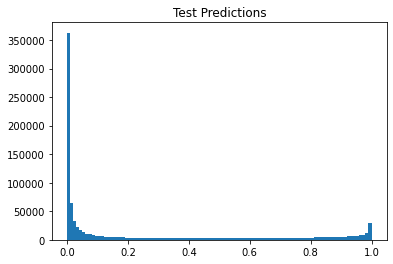

In [59]:
# visualize with hist plot.
plt.hist(sub.to_pandas().prediction, bins=100)
plt.title('Test Predictions')
plt.show()